# Introduction

In this notebook I explore the use of neural networks for image classification. I will do this by attempting the [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer/overview) Kaggle competition.


# Resources

[Competition Page](https://www.kaggle.com/c/digit-recognizer/data)

[GCS](https://console.cloud.google.com/storage/browser/kds-8947efbd7127c16ecaf06509c6fcfa9a8983e5a318604cad7c0baee3)

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math, re, os
from matplotlib import pyplot as plt

# Data

I am working in Google's colab enviornment rather than the notebooks Kaggle provides. There are multiple ways to access the competition data. Kaggle API can be used to download the data to the colab instance. The issue with this is that I would need to download the data each time a new instance is assigned. Since most of the Kaggle competition data exists in GCS, it can be used to directly access the data.

First we need to install gcsfs which will give us access to data in GCS. The link to the GCS bucket is listed in the Resources section.

In [2]:
# gcsfs required to read files from google cloud storage
! pip install gcsfs

The data is given in a data table format where each row is an image and columns represent the value of each pixel. There is an additional column for each image in the training csv which indicates the label.

I will use the pandas library to create dataframes from the provided csv files.

In [0]:
GCS_PATH = 'gs://kds-8947efbd7127c16ecaf06509c6fcfa9a8983e5a318604cad7c0baee3'
TRAIN_PATH = GCS_PATH + '/train.csv'
TEST_PATH = GCS_PATH + '/test.csv'

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

The following block defines certain images to be ignored in the labeled dataset provided. The process for picking these images is explained and implemented later in the notebook.

Later in the notebook, we will take a look at some of the misclassified images by our models. Many of these images are indeed misclassified by our model, however, a small subset of images are difficult to identify even for humans (in this case me). Ideally, one would want to verify the labels on all labeled images but it is not practical to do that for over 40,000 images. 

In [4]:
TRAIN_DATA_TO_IGNORE = [1979, 36018, 19478, 24477, 30275, 3923, 2981, 
                        11406, 5695, 26479, 18534, 32040, 37887, 7389, 10454, 
                        10941, 11593, 20954, 26785, 2915, 39990, 23604, 30278,
                        8260, 15081, 23299, 36408, 27977, 6543, 41691]
train_df.drop(TRAIN_DATA_TO_IGNORE, inplace=True)
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Keras framework will be used to create NN models in this notebook. For this we will need to separate images and labels while preserving order, and create a train/validation split. It is best practice to randomly select validation data when creating the split so we will shuffle the original dataframe rows to help achieve that.

In [0]:
# Split the images and labels for later use
train_labels = train_df['label']
train_data = train_df.drop(columns=['label'])

In [6]:
# shuffle the images to ensure the training and validation splits are random
shuffled_train_df = train_df.sample(frac=1)
shuffled_train_labels = shuffled_train_df['label']
shuffled_train_data = shuffled_train_df.drop(columns=['label'])

shuffled_train_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
31607,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,155,252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
print(train_labels.head())
print(train_data.head())
print(train_data.shape)
print(train_labels.shape)
print(test_df.shape)

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64
   pixel0  pixel1  pixel2  pixel3  ...  pixel780  pixel781  pixel782  pixel783
0       0       0       0       0  ...         0         0         0         0
1       0       0       0       0  ...         0         0         0         0
2       0       0       0       0  ...         0         0         0         0
3       0       0       0       0  ...         0         0         0         0
4       0       0       0       0  ...         0         0         0         0

[5 rows x 784 columns]
(41970, 784)
(41970,)
(28000, 784)


## Config and Visualization

The following visualization functions are adapted from a [Getting Started Notebook](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu/) from a different image classification competition

In [0]:
# Define constants and model hyperparameters
NUM_PIXELS = 784
IMG_SIZE = [28,28]
NUM_TESTS = test_df.shape[0]
NUM_LABELED = train_df.shape[0]
VAL_SPLIT_PERC = 0.15
NUM_VAL = int(VAL_SPLIT_PERC*NUM_LABELED)
NUM_TRAIN = NUM_LABELED - NUM_VAL
LABEL_COLUMN = 'label'
NUM_CLASSES = 10

In [0]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data, img_size=IMG_SIZE):
    images, labels = data
    numpy_images = images.numpy()

    if len(numpy_images.shape) < 4:
      numpy_images = numpy_images.reshape([numpy_images.shape[0], *img_size, 1])

    if labels is None:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    else:
        numpy_labels = labels.numpy()
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return label, True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_img(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    if image.shape[2] == 1:
      image = image[:,:,0]
    plt.imshow(image, cmap='Greys')
    if len(str(title)) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'white', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else label
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_img(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


# MLP

First we will feed the raw pixel data directly into a simple NN consisting only of fully connected layers. The input layer will have number of nodes equal to the total pixels (784), and the output layer will have 10 nodes representing the probability of each possible digit.

## Config

In this section, I will be creating tensorflow dataset objects that will be used for training. This is not necessary as we can simply fit a Keras model using numpy arrays.

In [0]:
BATCH_SIZE = 100
STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE
EPOCHS = 100

In [0]:
labeled_ds = tf.data.Dataset.from_tensor_slices((train_data.values, train_labels.values))
test_ds = tf.data.Dataset.from_tensor_slices(test_df.values)

In [0]:
# Display what the tf dataset looks like

# for feat, targ in labeled_ds.take(2):
#   print ('Features: {}, Target: {}'.format(feat, targ))

for feat in test_ds.take(2):
  print ('Features: {}'.format(feat))

Features: [0 0 0 ... 0 0 0]
Features: [0 0 0 ... 0 0 0]


Tensorflow dataset also provides easy methods to shuffle and split the labeled data. Since I did not used the shuffled dataframes to create the tf dataset above, I will use the shuffle method provided by the dataset class.

Tensorflow's dataset class also provides a simple way to batch our training data.

In [0]:
labeled_ds = labeled_ds.shuffle(NUM_LABELED)
val_ds = labeled_ds.take(NUM_VAL)
train_ds = labeled_ds.skip(NUM_VAL)

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

train_ds = train_ds.repeat(EPOCHS)

## Visualization

In [0]:
print("Training data shapes:")
for image, label in train_ds.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in val_ds.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image in test_ds.take(3):
    print(image.numpy().shape)


Training data shapes:
(100, 784) (100,)
(100, 784) (100,)
(100, 784) (100,)
Training data label examples: [2 8 5 ... 2 2 3]
Validation data shapes:
(100, 784) (100,)
(100, 784) (100,)
(100, 784) (100,)
Validation data label examples: [8 3 3 ... 3 3 3]
Test data shapes:
(784,)
(784,)
(784,)


In [0]:
train_ds_sample = train_ds.unbatch().batch(20)
train_batch = iter(train_ds_sample)

val_ds_sample = val_ds.unbatch().batch(20)
val_batch = iter(val_ds_sample)

test_ds_sample = test_ds.unbatch().batch(20)
test_batch = iter(test_ds_sample)

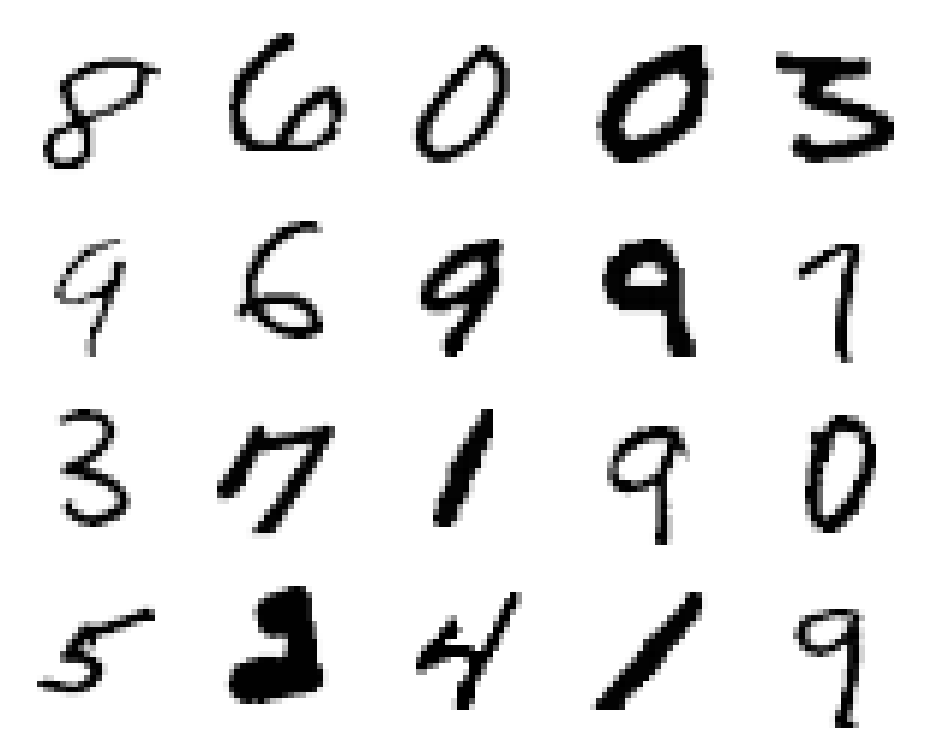

In [0]:
display_batch_of_images(next(train_batch))
# display_batch_of_images(next(val_batch))
# display_batch_of_images((next(test_batch), None))

## Model

The fully connected layer model I will use is simple: 

784 pixels -> 128 neurons -> relu -> 16 neurons -> relu -> 10 neurons -> softmax


I will use adam optimizer for gradient descent, and use sparse categorical crossentrophy as the loss function. Note that I use sparse_categorical_crossentrophy since the labels are integers from 0-9. If we had converted the labels to one-hot vectors, we would use categorical_crossentrophy instead.

I am also using the Rescaling layer provided in the experimental package to avoid having to remember to rescale any train, validation and test sets in the preprocessing stage

In [0]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling 

In [0]:
tf.keras.backend.clear_session()
mlp_model = tf.keras.Sequential([
  Rescaling(1./255, input_shape=[NUM_PIXELS])                         
  , Dense(128, activation='relu')
  , Dense(64, activation='relu')
  , Dense(NUM_CLASSES, activation='softmax')
])

mlp_model.compile(
    optimizer='adam'
    , loss = 'sparse_categorical_crossentropy'
    , metrics=['sparse_categorical_accuracy']
)
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


Keras provides several callback functions that can be used with the model.fit fucntion. I will use the EarlyStopping callback to ensure the model does not start to overfit the training set while performing worse on the validation set. The early stopping callback also allows the model to restore the best set of weights.

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='auto', verbose=1, restore_best_weights='True')

In [0]:
mlp_history = mlp_model.fit(train_ds, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/35
356/356 [==============================] - 1s 4ms/step - loss: 0.3895 - sparse_categorical_accuracy: 0.8917 - val_loss: 0.1773 - val_sparse_categorical_accuracy: 0.9459
Epoch 2/35
356/356 [==============================] - 2s 4ms/step - loss: 0.1560 - sparse_categorical_accuracy: 0.9542 - val_loss: 0.1154 - val_sparse_categorical_accuracy: 0.9684
Epoch 3/35
356/356 [==============================] - 2s 4ms/step - loss: 0.1125 - sparse_categorical_accuracy: 0.9674 - val_loss: 0.0856 - val_sparse_categorical_accuracy: 0.9749
Epoch 4/35
356/356 [==============================] - 2s 4ms/step - loss: 0.0836 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.0649 - val_sparse_categorical_accuracy: 0.9811
Epoch 5/35
356/356 [==============================] - 2s 4ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.0555 - val_sparse_categorical_accuracy: 0.9838
Epoch 6/35
356/356 [==============================] - 2s 4ms/step - loss: 0.0530 - sparse_categorica

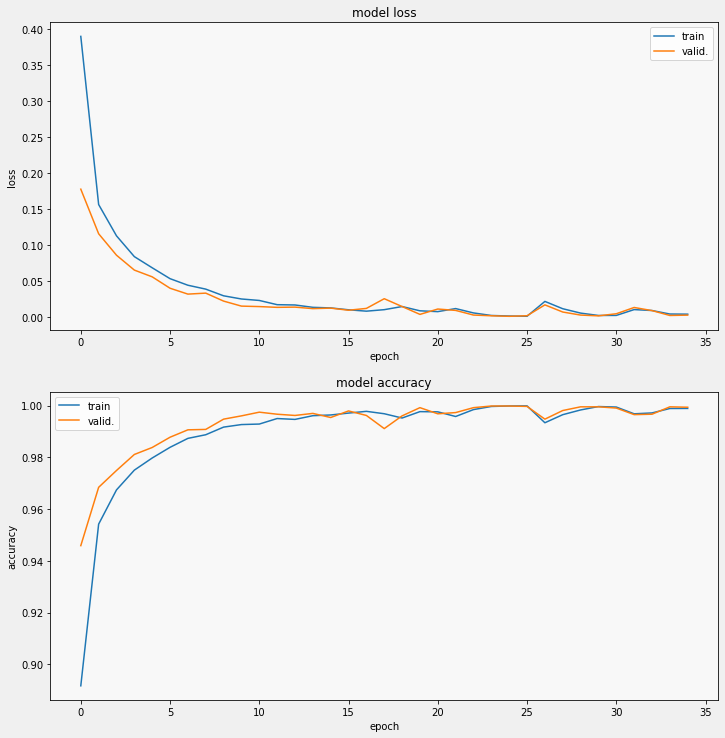

In [0]:
display_training_curves(mlp_history.history['loss'], mlp_history.history['val_loss'], 'loss', 211)
display_training_curves(mlp_history.history['sparse_categorical_accuracy'], mlp_history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

train_acc = round(mlp_history.history['sparse_categorical_accuracy'][-1],3)
val_acc = round(mlp_history.history['val_sparse_categorical_accuracy'][-1],3)

# file_name = 'model_t' + str(train_acc) + '_v_' + str(val_acc) + '.h5'
# model.save(file_name)

The traning and validation losses are very close together and do not diverge. This indicates that there is no overfitting issue with our model.

## Predictions

In [0]:
mlp_preds = np.argmax(mlp_model.predict(test_df.values), axis=-1)

In [0]:
mlp_submission = pd.DataFrame({'ImageId': range(1, 1+len(mlp_preds)), 'Label': mlp_preds })
mlp_submission.to_csv('mlp_submission.csv', index=False)

Upon submission to Kaggle, this model yields a test accuracy of 0.97742.
The submission was ranked at #2051 on the leaderboard at time of submission.

# CNN

In the last section we left the row data in its raw format and directly fed each pixel as a feature to a multilayer perceptron architecture. For image data, convolutional networks have proven to be more successful for classification tasks. In this section I will restrcture the data to be 28x28x1 b/w image that will be the input to a convolutonal network.

## Config and Preprocessing

In [0]:
BATCH_SIZE = 200
STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE
EPOCHS = 100

In [12]:
print('NUM_TRAIN = ', NUM_TRAIN, ', NUM_VAL = ', NUM_VAL, ', NUM_TESTS = ', NUM_TESTS)

NUM_TRAIN =  35675 , NUM_VAL =  6295 , NUM_TESTS =  28000


In this section, I will simply use numpy arrays to store the training and validation datasets rather than using tensorflow dataset class.

In [13]:
labeled_nparr = shuffled_train_data.to_numpy()
test_nparr = test_df.to_numpy()
labels_nparr = shuffled_train_labels.to_numpy()
print('labeled set: ' , labeled_nparr.shape, ' labels: ', labels_nparr.shape)
print('test set: ', test_nparr.shape)

labeled set:  (41970, 784)  labels:  (41970,)
test set:  (28000, 784)


In [0]:
# test = np.array([[1,2,3,4,5,6,7,8,9], [6,7,8,9,10,11,12,13,14]])
# print(test)
# print(test.shape)
# print(np.reshape(test, [2,3,3]))

Keras Conv2D layers expects the input to be in the following format: (batch_size, img_width, img_height, channels)

Since the dataset is grayscale, channels = 1.

In [15]:
labeled_nparr = np.reshape(labeled_nparr, [NUM_LABELED, *IMG_SIZE, 1])
test_nparr = np.reshape(test_nparr, [NUM_TESTS, *IMG_SIZE, 1])
print(labeled_nparr.shape)
print(test_nparr.shape)

(41970, 28, 28, 1)
(28000, 28, 28, 1)


Since the labeled dataset is created from the shuffled dataframe, the validation split is created by simply taking the last n examples of the labeled dataset.

In [16]:
train_nparr = labeled_nparr[:NUM_TRAIN, :, :, :]
train_labels = labels_nparr[:NUM_TRAIN]
val_nparr = labeled_nparr[NUM_TRAIN:, :, :, :]
val_labels = labels_nparr[NUM_TRAIN:]

print(train_nparr.shape, ', ', train_labels.shape)
print(val_nparr.shape, ', ', val_labels.shape)


(35675, 28, 28, 1) ,  (35675,)
(6295, 28, 28, 1) ,  (6295,)


Generally, image data would also be rescaled during preprocessing so eack pixel value is between 0 and 1. I will instead be using an experimental layer provided by keras to implement rescaling as part of the ML model. 

## Models

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling 
from tensorflow.keras.callbacks import ModelCheckpoint

As the validation loss apporaches its minima, it does not always converge and be start to increase after too much training. I will use the checkpoint callback to store the weights at the end of each epoch (given that the validation accurace improved from the current best).

In [0]:
checkpoint = ModelCheckpoint('digit_model-v_{val_sparse_categorical_accuracy:03f}-t_{sparse_categorical_accuracy:03f}.h5', verbose=1, monitor='val_sparse_categorical_accuracy',save_best_only=True, mode='auto')  

In [38]:
tf.keras.backend.clear_session()
cnn_model = tf.keras.Sequential([
        Rescaling(1./255, input_shape=(*IMG_SIZE,1))
      , Conv2D(16, (5,5), activation='relu')
      , MaxPooling2D(pool_size=(2,2))
      , Conv2D(32, (3,3), activation='relu')
      , Conv2D(64, (3,3), activation='relu')
      , MaxPooling2D(pool_size=(2,2))
      , Flatten()
      , Dropout(0.5)
      , Dense(128, activation='relu')
      , Dropout(0.25)
      , Dense(64, activation='relu')
      , Dropout(0.25)
      , Dense(NUM_CLASSES, activation='softmax')                 
])

cnn_model.compile(
    optimizer='adam'
    , loss = 'sparse_categorical_crossentropy'
    , metrics=['sparse_categorical_accuracy']
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

## Train Model

In [22]:
cnn_history = cnn_model.fit(x=train_nparr, y=train_labels, callbacks=[checkpoint], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_nparr, val_labels))

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.6237 - sparse_categorical_accuracy: 0.7952
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.96680, saving model to digit_model-v_0.966799-t_0.795179.h5
179/179 [==============================] - 3s 14ms/step - loss: 0.6237 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.1132 - val_sparse_categorical_accuracy: 0.9668
Epoch 2/100
174/179 [============================>.] - ETA: 0s - loss: 0.1622 - sparse_categorical_accuracy: 0.9509
Epoch 00002: val_sparse_categorical_accuracy improved from 0.96680 to 0.97792, saving model to digit_model-v_0.977919-t_0.951030.h5
179/179 [==============================] - 2s 11ms/step - loss: 0.1616 - sparse_categorical_accuracy: 0.9510 - val_loss: 0.0682 - val_sparse_categorical_accuracy: 0.9779
Epoch 3/100
175/179 [============================>.] - ETA: 0s - loss: 0.1183 - sparse_categorical_accuracy: 0.9653
Epoch 00003: val_sparse_categorical_accuracy improv

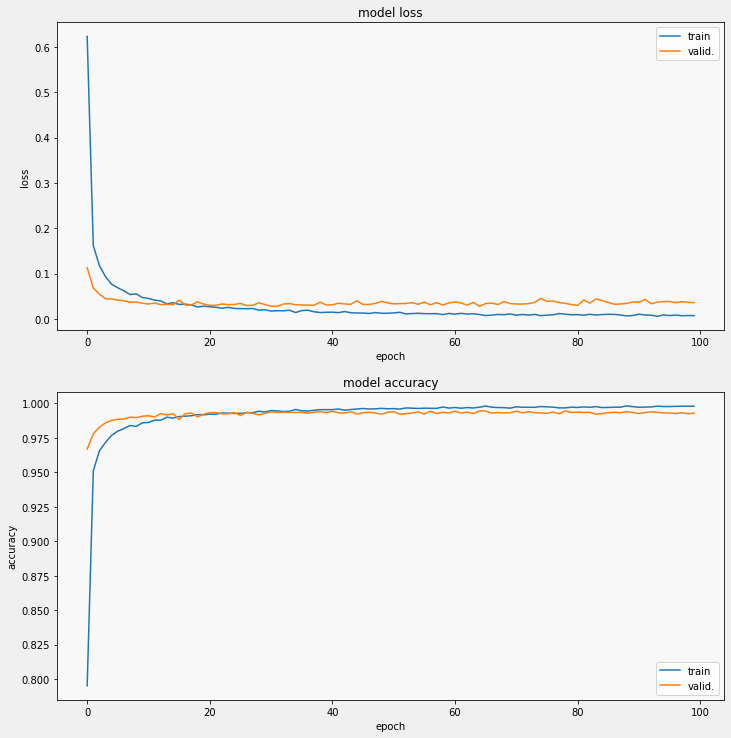

In [23]:
display_training_curves(cnn_history.history['loss'], cnn_history.history['val_loss'], 'loss', 211)
display_training_curves(cnn_history.history['sparse_categorical_accuracy'], cnn_history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

train_acc = round(cnn_history.history['sparse_categorical_accuracy'][-1],3)
val_acc = round(cnn_history.history['val_sparse_categorical_accuracy'][-1],3)

# file_name = 'model_t' + str(train_acc) + '_v_' + str(val_acc) + '.h5'
# model.save(file_name)

This model tends to give a training accuracy around 99.7-99.8%, and validation accuracy around 99.4-99.5%.
The Kaggle submission results in a test accuracy of 99.37%

In the next section I will try to use augmentation to try and improve the Kaggle result

## Train with augmentation

Keras preprocessing module provides a good range of out of the box augmentation implementations. I will use the ImageDataGenerator to randomly apply a small set of transformations:

- image rotataion
- zooming
- horizontal shifts
- vertical shifts

The rotation range is kept small since rotated digits sometimes look like other digits or make no sense at all.

Zooming and shifts also need to be small since most of the training dataset is zoomed and focussed on the digit (look at the visualization section under MLP). Large numbers for these parameters would result in the digit losing important information. 

In [0]:
augmented_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15
    , zoom_range=0.15
    , width_shift_range=0.15
    , height_shift_range=0.15
)

In [61]:
aug_cnn_history = cnn_model.fit(
    augmented_gen.flow(train_nparr, train_labels, batch_size=BATCH_SIZE)
    , callbacks=[checkpoint]
    , epochs=EPOCHS 
    , steps_per_epoch=STEPS_PER_EPOCH
    , validation_data=(val_nparr, val_labels)
)

Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 0.0796 - sparse_categorical_accuracy: 0.9777
Epoch 00001: val_sparse_categorical_accuracy did not improve from 0.99539
178/178 [==============================] - 15s 83ms/step - loss: 0.0796 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.0291 - val_sparse_categorical_accuracy: 0.9925
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 0.0620 - sparse_categorical_accuracy: 0.9827
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.99539
178/178 [==============================] - 15s 86ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.0287 - val_sparse_categorical_accuracy: 0.9935
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 0.0593 - sparse_categorical_accuracy: 0.9830
Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.99539
178/178 [==============================] - 15s 84ms/step - loss: 0.0593 - sparse_categor

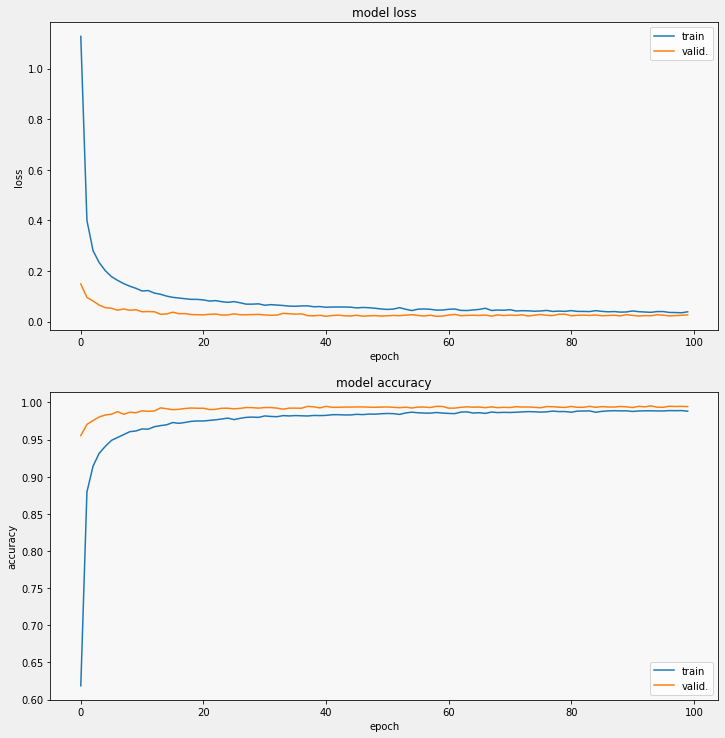

In [41]:
display_training_curves(aug_cnn_history.history['loss'], aug_cnn_history.history['val_loss'], 'loss', 211)
display_training_curves(aug_cnn_history.history['sparse_categorical_accuracy'], aug_cnn_history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

train_acc = round(aug_cnn_history.history['sparse_categorical_accuracy'][-1],3)
val_acc = round(aug_cnn_history.history['val_sparse_categorical_accuracy'][-1],3)

# file_name = 'model_t' + str(train_acc) + '_v_' + str(val_acc) + '.h5'
# model.save(file_name)

## Predictions

Load the best set of weights for the model and create a submission csv.

In [0]:
cnn_model = tf.keras.models.load_model('/content/digit_model-v_0.995393-t_0.990754.h5')
cnn_preds = np.argmax(cnn_model.predict(test_nparr), axis=-1)

In [57]:
cnn_submission = pd.DataFrame({'ImageId': range(1, 1+len(cnn_preds)), 'Label': cnn_preds })
cnn_submission.to_csv('cnn_submission.csv', index=False)

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


Upon submission to Kaggle, the best submission yields a test accuracy of 0.99571.
The submission was ranked at #391 on the leaderboard at time of submission.

# Model Analysis

In this section I will try and do some analysis on the model trained previously.

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [0]:
# If loading previously trained model:
# model = tf.keras.models.load_model('/content/digit_model-v_0.996429-t_0.995979.h5')
# model.summary()

#If using cnn_model trained in this session
model = cnn_model

In [0]:
# val_images = val_ds.map(lambda image, label: image)
# val_labels = val_ds.map(lambda image, label: label).unbatch()
# true_val_labels = next(iter(val_labels.batch(NUM_VAL))).numpy()
# model_val_labels = np.argmax(model.predict(val_images), axis=-1)
# print("Correct   labels: ", true_val_labels.shape, true_val_labels)
# print("Predicted labels: ", model_val_labels.shape, model_val_labels)

In [49]:
model_labels = np.argmax(model.predict(val_nparr), axis=-1)
true_labels = val_labels
print("Correct   labels: ", true_labels.shape, true_labels)
print("Predicted labels: ", model_labels.shape, model_labels)

Correct   labels:  (6295,) [8 3 6 ... 7 4 9]
Predicted labels:  (6295,) [8 3 6 ... 7 4 9]


A good method of analysing the results of a multiclass classification prediction is to create a confusion matrix. It can help point out the classes that the model strugges with most.

In [0]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_xticklabels([str(x) for x in range(NUM_CLASSES)], fontdict={'fontsize': 12}, color='w')
    plt.setp(ax.get_xticklabels(), ha="left", rotation_mode="anchor")
    ax.set_yticks(range(NUM_CLASSES))
    ax.set_yticklabels([str(x) for x in range(NUM_CLASSES)], fontdict={'fontsize': 12}, color='w')
    plt.setp(ax.get_yticklabels(), ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(9, 0, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

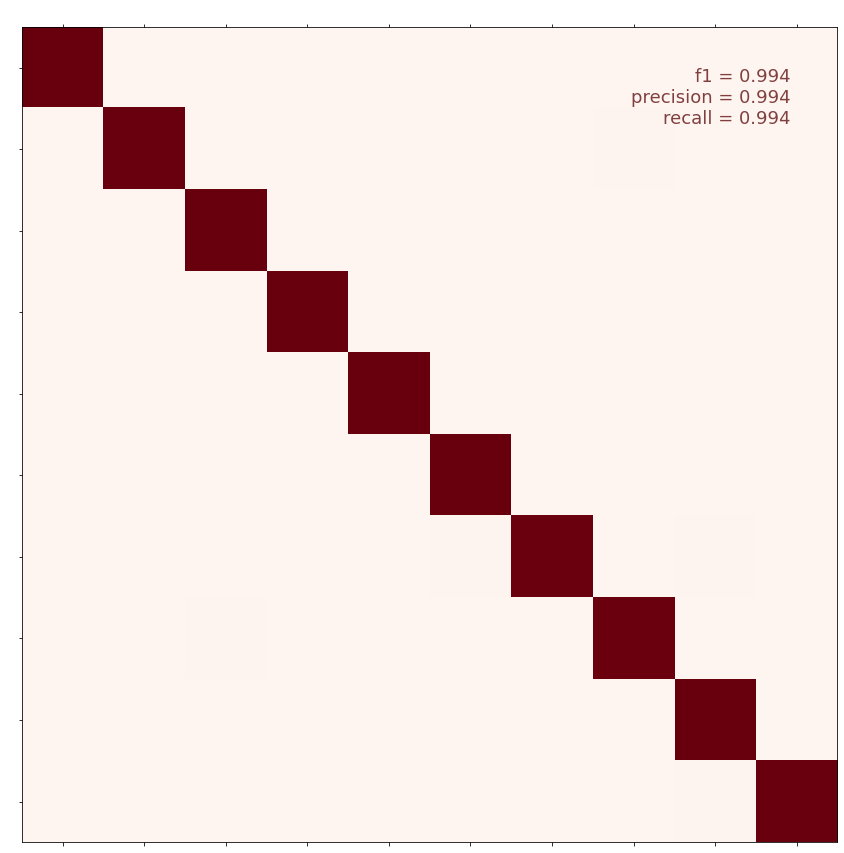

f1 score: 0.994, precision: 0.994, recall: 0.994


In [53]:
cmat = confusion_matrix(true_labels, model_labels, labels=range(NUM_CLASSES))
score = f1_score(true_labels, model_labels, labels=range(NUM_CLASSES), average='macro')
precision = precision_score(true_labels, model_labels, labels=range(NUM_CLASSES), average='macro')
recall = recall_score(true_labels, model_labels, labels=range(NUM_CLASSES), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

The confusion matrix does not indicate any particular digits that our model is having a problem with.

Next, I will try and pinpoint the validation examples that the model has failed on to see if we can gain any insights.

In [54]:
wrong_indices = np.flatnonzero(true_labels != model_labels)
print('number of incorrect validation classifications: ', len(wrong_indices), ', ', wrong_indices)

wrong_images = np.take(val_nparr, wrong_indices, axis=0)
print('Shape of validation set: ', val_nparr.shape, ', Shape of incorrect subset: ', wrong_images.shape)

correct_labels_subset = np.take(val_labels, wrong_indices, axis=0)
print('Shape of validation labels: ', val_labels.shape, ', Shape of true labels for incorrectly classified subset: ', correct_labels_subset.shape)

wrong_predictions = np.take(model_labels, wrong_indices, axis=0)
print('Shape of predicted labels: ', model_labels.shape, ', Shape of incorrect subset of predicted labels: ', wrong_predictions.shape)

number of incorrect validation classifications:  35 ,  [ 245  395  758 ... 5899 5976 6024]
Shape of validation set:  (6295, 28, 28, 1) , Shape of incorrect subset:  (35, 28, 28, 1)
Shape of validation labels:  (6295,) , Shape of true labels for incorrectly classified subset:  (35,)
Shape of predicted labels:  (6295,) , Shape of incorrect subset of predicted labels:  (35,)


In [0]:
def title_from_label_and_target(label, correct_label, img_num):
    if correct_label is None:
        return label, True
    correct = (label == correct_label)
    return "{} : {} [{}{}{}]".format(img_num, label, 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_img(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    if image.shape[2] == 1:
      image = image[:,:,0]
    plt.imshow(image, cmap='Greys')
    if len(str(title)) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'white', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_np_images(images, labels, predictions=None, img_nums=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    if labels is None:
        labels = [None for _ in range(images.shape[0])]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows + 1
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else label
        correct = True
        img_num = i if img_nums is None else img_nums[i]
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label, img_num)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_img(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


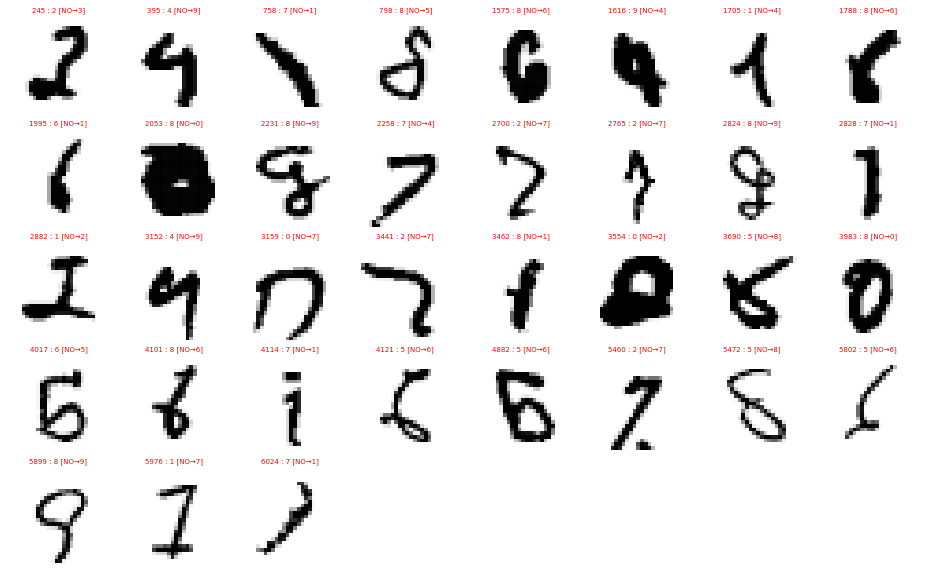

In [56]:
display_np_images(wrong_images, correct_labels_subset, wrong_predictions, wrong_indices)

The good news is that most of the digits that were is classified are not very good drawings of the digit and can be troublesom even for humans to decipher. Our model is not really struggling with very obvious digits. 

Moreover, there are certain images where it is clearly mislabeled and some where it is hard for even a human to guess the digit without the label. 

Below I will identify the original id of images that are mislabeled or illegible and remove them from the labeled set when re-training.

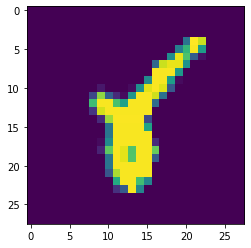

In [0]:
plt.imshow(val_nparr[1766, :, :, 0])

The following images in the validation set are arguably false or not human readable:

In [0]:
val_indices = np.array([1400, 2870, 3540])
shuffled_indices = val_indices + NUM_TRAIN
print(shuffled_indices)

[39176 40646 41316]


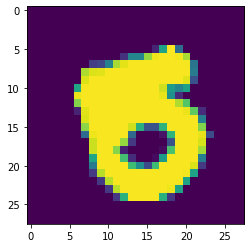

In [0]:
plt.imshow(shuffled_train_data.iloc[39161].to_numpy().reshape(IMG_SIZE))

5695


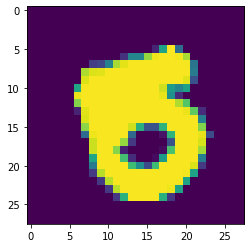

In [0]:
orig_idx = shuffled_train_df.iloc[39161].name
print(orig_idx)
plt.imshow(train_data.loc[orig_idx].to_numpy().reshape(IMG_SIZE))

In [0]:
original_indices = []
for shuffled_idx in shuffled_indices:
  original_indices.append(shuffled_train_df.iloc[shuffled_idx].name)

print(original_indices)

[27977, 6543, 41691]


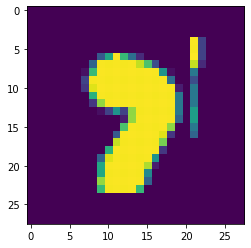

In [0]:
plt.imshow(train_data.loc[2981].to_numpy().reshape(IMG_SIZE))

After several iterations of finding mislabeled and illegible images, the validation and test (submission) accuracy did improve by a small amount. This effort would need to be done at a larger scale for it to have a bigger impact on the results.

# Summary

This notebook walks through my efforts for trying to achieve the best possible score for the Digit Recognizer Kaggle competition. 

I begin by simply stacking multiple dense layers (multilayer perceptron) and feeding each pixel value of an image as a feature. This technique gave led to very high training and validation accuracies (approx 1), however, it's performance on the test data was mediocre with a 97.7% accuracy. 

In attempt to allow the model to generalize better by learning image features, I build a convolutional network. The goal of this type of network is to use convolutions to detect features (edges, shapes, etc.) in an image and feed those features to a dense network. The CNN model does not quite approach training and validation accuracy of 1 like the MLP, however, the model performs significantly better on the test data.

To further help the model generalize, I train the CNN with augmented data. This lowers the training accuracy but yields a noticable increase in validation and test accuracies. 